# Transformer
⽐较了卷积神经⽹络（CNN）、循环神经⽹络（RNN）和⾃注意⼒（self-attention）。值得注意的是，⾃注意⼒同时具有并⾏计算和最短的最⼤路径⻓度这两个优势。因此，使⽤⾃注意⼒来设计深度架构是很有吸引⼒的。对⽐之前仍然依赖循环神经⽹络实现输⼊表⽰的⾃注意⼒模型 (Cheng et al., 2016, Lin et al., 2017,
Paulus et al., 2017)，Transformer模型完全基于注意⼒机制，没有任何卷积层或循环神经⽹络层 (Vaswani et
al., 2017)。尽管Transformer最初是应⽤于在⽂本数据上的序列到序列学习，但现在已经推⼴到各种现代的深度学习中，例如语⾔、视觉、语⾳和强化学习领域。

## 1. 模型
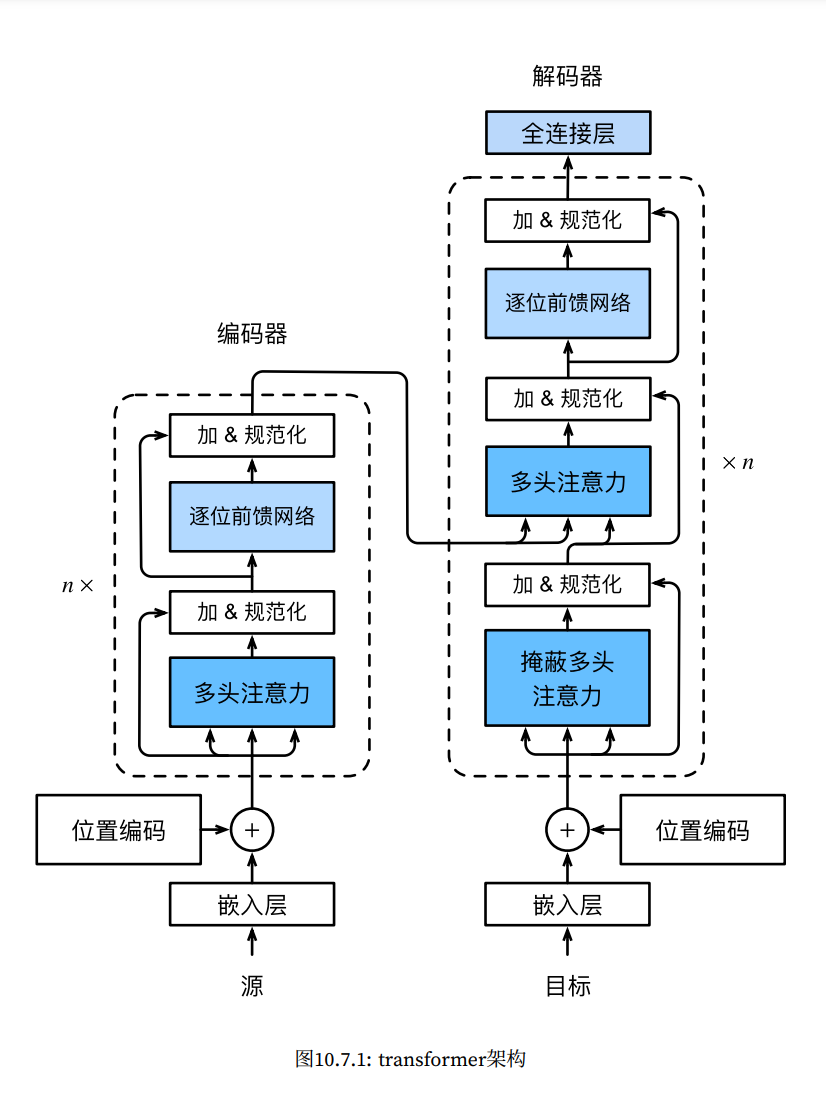
从宏观⻆度来看，Transformer的编码器是由多个相同的层叠加⽽
成的，每个层都有两个⼦层（⼦层表⽰为sublayer）。第⼀个⼦层是多头⾃注意⼒（multi-head self-attention）汇聚；第⼆个⼦层是基于位置的前馈⽹络（positionwise feed-forward network）。具体来说，在计算编码器的⾃注意⼒时，查询、键和值都来⾃前⼀个编码器层的输出。受 7.6节中残差⽹络的启发，每个⼦层都采⽤了残差连接（residual connection）。在残差连接的加法计算之后，紧接着应⽤层规范化（layer normalization）(Ba et al., 2016)。因此，输⼊序列对应的每个位置，Transformer编码器都将输出⼀个d维表⽰向量。

Transformer解码器也是由多个相同的层叠加⽽成的，并且层中使⽤了残差连接和层规范化。除了编码器中描述的两个⼦层之外，解码器还在这两个⼦层之间插⼊了第三个⼦层，称为编码器－解码器注意⼒（encoderdecoder attention）层。在编码器－解码器注意⼒中，查询来⾃前⼀个解码器层的输出，⽽键和值来⾃整个编码器的输出。在解码器⾃注意⼒中，查询、键和值都来⾃上⼀个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种掩蔽（masked）注意⼒保留了⾃回归（auto-regressive）属性，确
保预测仅依赖于已⽣成的输出词元。



In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 2. 基于位置的前馈神经网络
基于位置的前馈⽹络对序列中的所有位置的表⽰进⾏变换时使⽤的是同⼀个多层感知机（MLP），这就是称
前馈⽹络是基于位置的（positionwise）的原因。在下⾯的实现中，输⼊X的形状（批量⼤⼩，时间步数或序列
⻓度，隐单元数或特征维度）将被⼀个两层的感知机转换成形状为（批量⼤⼩，时间步数，ffn_num_outputs）
的输出张量。
**将输出形状由(b, n, d)转变为(bn, d),这里的n为序列长度，但是序列长度为可变的，不应该作为一个特征维度，模型应该可以接受任意长度的输入序列(感觉就是cnn里面的1x1卷积核的作用)**

In [2]:
#@save
class PositionWiseFFN(nn.Module):
    # 基于位置的前馈神经网络
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outoputs,
                **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outoputs)
        
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

下⾯的例⼦显⽰，改变张量的最⾥层维度的尺⼨，会改变成基于位置的前馈⽹络的输出尺⼨。因为⽤同⼀个
多层感知机对所有位置上的输⼊进⾏变换，所以当所有这些位置的输⼊相同时，它们的输出也是相同的。


In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.2615,  0.5094, -0.3368, -0.2286, -0.3981,  0.5295, -0.5867,  0.1563],
        [ 0.2615,  0.5094, -0.3368, -0.2286, -0.3981,  0.5295, -0.5867,  0.1563],
        [ 0.2615,  0.5094, -0.3368, -0.2286, -0.3981,  0.5295, -0.5867,  0.1563]],
       grad_fn=<SelectBackward0>)

## 3. 残差连接和层规范化

加法和规范化（add&norm）组件，这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。在前面节中解释了在⼀个⼩批量的样本内基于批量规范化对数据进⾏重新中⼼化和重新缩放的调整。层规范化和批量规范化的⽬标相同，但层规范化是基于特征维度进⾏规范化。尽管批量规范化在计算机视觉中被⼴泛
应⽤，但在⾃然语⾔处理任务中（输⼊通常是变⻓序列）批量规范化通常不如层规范化的效果好。
+ **layer normalization是在一个样本中进行规范化，而不是在一个特征中。因为处理自然文本时，输入序列长度会变，采用批规范化会出现不稳定的现象，采用层规范化更稳定一点，不会因为序列长度的变化而导致规范化效果波动**

In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式计算x的均值和方差
print('layer norm: ', ln(X), '\nbatch norm: ', bn(X))

layer norm:  tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm:  tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在可以使⽤残差连接和层规范化来实现AddNorm类。暂退法也被作为正则化⽅法使⽤。


In [5]:
#AddNorm
#@save
class AddNorm(nn.Module):
    
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
        
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [6]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 4. 编码器
有了组成Transformer编码器的基础组件，现在可以先实现编码器中的⼀个层。下⾯的EncoderBlock类包含
两个⼦层：多头⾃注意⼒和基于位置的前馈⽹络，这两个⼦层都使⽤了残差连接和紧随的层规范化。



In [7]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
                                key_size, query_size, value_size, num_hiddens, num_heads, dropout,
                                use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
                    ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))


Transformer编码器中的任何层都不会改变其输⼊的形状。


In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape


torch.Size([2, 100, 24])

下⾯实现的Transformer编码器的代码中，堆叠了num_layers个EncoderBlock类的实例。由于这⾥使⽤的是
值范围在−1和1之间的固定位置编码，因此通过学习得到的输⼊的嵌⼊表⽰的值需要先乘以嵌⼊维度的平⽅
根进⾏重新缩放，然后再与位置编码相加。

In [9]:
#@save
class TransformerEncoder(d2l.Encoder):
    # Transformer编码器
    def __init__(self, vocab_size, key_size, query_size, value_size,
                num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block'+str(i),
                                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                            norm_shape, ffn_num_input, ffn_num_hiddens,
                                            num_heads, dropout, use_bias))
            
            
    
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌⼊值乘以嵌⼊维度的平⽅根进⾏缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [10]:
encoder = TransformerEncoder(
200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape


torch.Size([2, 100, 24])

## 5. 解码器
Transformer解码器也是由多个相同的层组成。在DecoderBlock类中实现的每个层包含了三个⼦层：解码器⾃注意⼒、“编码器-解码器”注意⼒和基于位置的前馈⽹络。这些⼦层也都被残差连接和紧
随的层规范化围绕。    


正如在本节前⾯所述，在掩蔽多头解码器⾃注意⼒层（第⼀个⼦层）中，查询、键和值都来⾃上⼀个解码器层的输出。关于序列到序列模型（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然⽽，在预测阶段，其输出序列的词元是逐个⽣成的。因此，在任何解码器时间步中，只有⽣成的词元才能⽤于解码器的⾃注意⼒计算中。为了在解码器中保留⾃回归的属性，其掩蔽⾃注意⼒设定了参数dec_valid_lens，以便任何查询都只会与解码器中所有已经⽣成词元的位置（即直到该查询
位置为⽌）进⾏注意⼒计算。


+ **编码器中的输出y1-yn将作为decoder中第i个transformer块的key和value，query则来自于target sequence，这意味着encoder和decoder中的块的个数和输出维度是一样的**

In [11]:
class DecoderBlock(nn.Module):
    # 解码器第i个块
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                dropout, i ,**kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout
        )
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                  num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同⼀时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元⼀个接着⼀个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表⽰
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每⼀⾏是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device
            ).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
            
        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # encoder-decoder attention
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

为了便于在“编码器－解码器”注意⼒中进⾏缩放点积计算和残差连接中进⾏加法计算，编码器和解码器的
特征维度都是num_hiddens。


In [12]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [17]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block'+str(i),
                                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                            norm_shape, ffn_num_input, ffn_num_hiddens,
                                            num_heads, dropout, i))
            self.dense = nn.Linear(num_hiddens, vocab_size)
            
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # 编码器-解码器 自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.034, 3453.8 tokens/sec on cpu


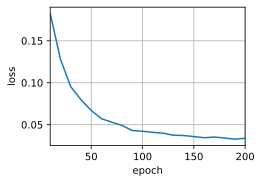

In [18]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout
)

decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout
)

net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使⽤Transformer模型将⼀些英语句⼦翻译成法语，并且计算它们的BLEU分数。

## 6. 预测
**transformer decoder在预测第t+1个输出时，decoder输入前t个预测值。在self-attention中，前t个值作为key和value，第t个值作为query**

In [19]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
            f'bleu {d2l.bleu(translation, fra, k=2):.3f}')


go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


当进⾏最后⼀个英语到法语的句⼦翻译⼯作时，让我们可视化Transformer的注意⼒权重。编码器⾃注意⼒
权重的形状为（编码器层数，注意⼒头数，num_steps或查询的数⽬，num_steps或“键－值”对的数⽬）。

In [20]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
                            -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

在编码器的⾃注意⼒中，查询和键都来⾃相同的输⼊序列。因为填充词元是不携带信息的，因此通过指定输
⼊序列的有效⻓度可以避免查询与使⽤填充词元的位置计算注意⼒。接下来，将逐⾏呈现两层多头注意⼒的
权重。每个注意⼒头都根据查询、键和值的不同的表⽰⼦空间来表⽰不同的注意⼒。

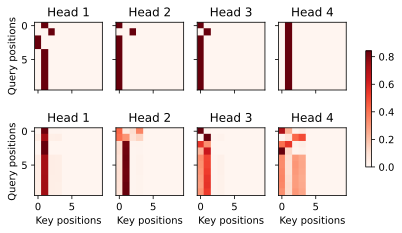

In [21]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))


为了可视化解码器的⾃注意⼒权重和“编码器－解码器”的注意⼒权重，我们需要完成更多的数据操作⼯作。
例如⽤零填充被掩蔽住的注意⼒权重。值得注意的是，解码器的⾃注意⼒权重和“编码器－解码器”的注意
⼒权重都有相同的查询：即以序列开始词元（beginning-of-sequence,BOS）打头，再与后续输出的词元共同组成序列。


In [24]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape


(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

由于解码器⾃注意⼒的⾃回归属性，查询不会对当前位置之后的“键－值”对进⾏注意⼒计算。


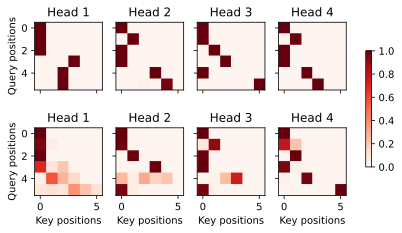

In [25]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))


与编码器的⾃注意⼒的情况类似，通过指定输⼊序列的有效⻓度，输出序列的查询不会与输⼊序列中填充位
置的词元进⾏注意⼒计算。


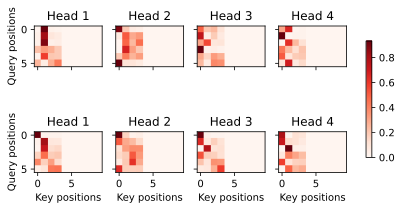

In [26]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))


尽管Transformer架构是为了序列到序列的学习⽽提出的，但正如本书后⾯将提及的那样，Transformer编码器或Transformer解码器通常被单独⽤于不同的深度学习任务中。


## 总结
+ Transformer是编码器－解码器架构的⼀个实践，尽管在实际情况中编码器或解码器可以单独使⽤。
+ 在Transformer中，多头⾃注意⼒⽤于表⽰输⼊序列和输出序列，不过解码器必须通过掩蔽机制来保留⾃回归属性。
+ Transformer中的残差连接和层规范化是训练⾮常深度模型的重要⼯具。
+ Transformer模型中基于位置的前馈⽹络使⽤同⼀个多层感知机，作⽤是对所有序列位置的表⽰进⾏转换。